In [ ]:
# default_exp datasets

In [ ]:
# hide
# missing
!git clone https://github.com/marcomatteo/steel_segmentation.git

In [ ]:
# hide
# missing
!pip install -e steel_segmentation

# Datasets

> Loading data for training DL models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/dev_nbs/03_datasets.ipynb)

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from steel_segmentation.metadata import *
from steel_segmentation.masks import *

from fastcore.test import *
from fastai.vision.all import *
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split

from PIL import Image
import pandas as pd
import numpy as np
import os
import cv2

from torch.utils.data import Dataset, sampler
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
import albumentations as alb

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()
train_pivot = train_pivot.loc[train_pivot.index.isin(only_imgs)]

## Classification

I take this section to study the layered approach of the `fastai` library for the classification `Dataset` construction. 

The following code will not be exported into the library because it's it will be covered in the `dataloaders.ipynb`.
It's only a verbose documentation used to undestand better the high level API.

In [ ]:
# defected images only
df = train_multi.loc[train_multi["ClassId_multi"]!='0']

### DataBlock API

Fast.ai Datablock API is the access point to build `fastai.data.core.Datasets` and `fastai.data.core.DataLoaders`.

To build a `DataBlock` we need:
- a list of `TransformBlock`: a pipeline of transforms applied to the indipendent and dipendent variables,

- a `get_x` and `get_y` method: to hook the variables from the source (explained later),

- a `splitter`: a list of indexes used to separate the training from the validation set,

- a `batch_tfms`: a list of transforms to be applied after the batch creation (used for dataloaders).

The object creation is only for setup purposes, it needs a source to be applied on.

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock()),
    get_x=ColReader(0, pref=train_path),
    get_y=ColReader(1, label_delim=' '),
    splitter=RandomSplitter(valid_pct=0.2))

Now we can check that is all right by passing a `source` into the `dblock` and the API returns all the creation process explained.

In [ ]:
# only defected images
dsets = dblock.datasets(df, verbose=True)

0        0002cc93b.jpg             1
4        0007a71bf.jpg             3
5        000a4bcdd.jpg             1
6        000f6bf48.jpg             4
7        0014fce06.jpg             3
...                ...           ...
12560    ffcf72ecf.jpg             3
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[6666 rows x 2 columns]
Found 6666 items
2 datasets of sizes 5333,1333
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': Path('../data/train_images'), 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}


Now we have an object that wraps the training and the validation dataset.

In [ ]:
len(dsets.train), len(dsets.valid), type(dsets.valid)

(5333, 1333, fastai.data.core.Datasets)

The attribute `vocab` has all the types of labels.

In [ ]:
dsets.vocab

['0', '1', '2', '3', '4']

As a dataset in pure Pytorch, it has the `__getitem__` and `__len__` methods implemented.

In [ ]:
t = dsets.train[0]
t

(PILImage mode=RGB size=1600x256, TensorMultiCategory([0., 0., 1., 0.]))

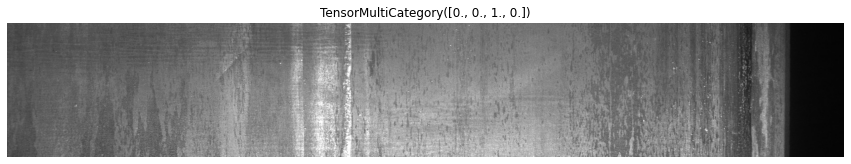

In [ ]:
#missing
show_titled_image(t, figsize=(15,5));

To visualize the decoded label we can use `dsets.decode`:

In [ ]:
t_decoded = dsets.decode(t)
t_decoded

(PILImage mode=RGB size=1600x256, (#1) ['3'])

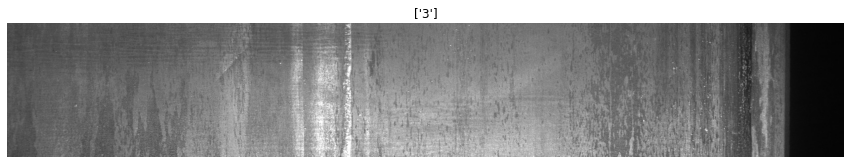

In [ ]:
#missing
show_titled_image(t_decoded, figsize=(15,5));

### Middle level API:

To better understand the DataBlock API we can view every step a little bit closer with the so called "Middle level API" in `fastai`.

Here we use the same `get_x` transform and we get the image path of the first element in the `source`.

In [ ]:
get_x = ColReader(0, pref=train_path)
item = df.iloc[0] 
get_x(item)

'../data/train_images/0002cc93b.jpg'

Next we use a `type_tfms` to open the image path and create a `PILImage`:

In [ ]:
open_x = PILImage.create
tls_x = TfmdLists(df, [get_x, open_x])

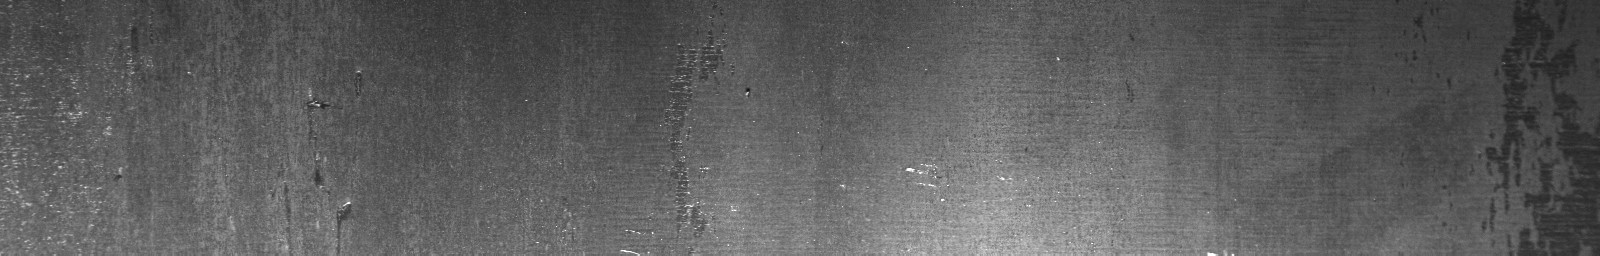

In [ ]:
#missing
t = tls_x[0]
t

These steps are can be collected into a special `fastai` pipeline. The same process can be applied for the labels:

In [ ]:
get_y = ColReader(1, label_delim=' ')
cat_y = MultiCategorize()
one_hot_y = OneHotEncode()
tls_y = TfmdLists(train_multi, [get_y, cat_y, one_hot_y])

In [ ]:
tls_y[0], tls_y.tfms.decode(tls_y[0])[0]

(TensorMultiCategory([0., 1., 0., 0., 0.]), '1')

Finally, the same result can be obtained in one cell:

In [ ]:
x_tfms = Pipeline([get_x, open_x])
y_tfms = Pipeline([get_y, cat_y, one_hot_y])
dsets = Datasets(df, [x_tfms, y_tfms])

In [ ]:
dsets[0], dsets.decode(dsets[0])

((PILImage mode=RGB size=1600x256, TensorMultiCategory([0., 1., 0., 0., 0.])),
 (PILImage mode=RGB size=1600x256, (#1) ['1']))

## Cross-validation with K-Fold splitting

A common approach to evaluate ML models is cross-validation. In this section we first create a test set and then the K-fold from the training data:

In [ ]:
n = len(train)
split = train_test_split(range(n), test_size=0.2, random_state=69)
len(split[0]), len(split[1])

(5676, 1419)

In [ ]:
# without cross-validation
dsets = Datasets(train, [x_tfms, y_tfms], splits=split)

With [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) `StratifiedKFold`:

In [ ]:
df_train = train.iloc[split[0]]
df_test = train.iloc[split[1]]
df_train.shape, df_test.shape

((5676, 4), (1419, 4))

In [ ]:
df_train.ClassId.value_counts().to_frame()

,ClassId
3,4148
1,706
4,627
2,195


In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=69)
skf

StratifiedKFold(n_splits=3, random_state=69, shuffle=True)

In [ ]:
#missing
X = df_train["ImageId"].to_numpy()
y = df_train["ClassId"].to_numpy()

In [ ]:
#missing
dsets = []
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(
        f"Fold-{i}:",
        f"Train: #{len(train_index)}, e.g. {train_index[:5]}", 
        f"Valid: #{len(valid_index)}, e.g. {valid_index[:5]}", 
        sep='\n', end='\n\n')
    split = [train_index, valid_index]
    dsets.append(Datasets(df_train, [x_tfms, y_tfms], splits=split))

Fold-0:
Train: #3784, e.g. [0 2 5 6 7]
Valid: #1892, e.g. [ 1  3  4  9 12]

Fold-1:
Train: #3784, e.g. [0 1 3 4 7]
Valid: #1892, e.g. [ 2  5  6 10 14]

Fold-2:
Train: #3784, e.g. [1 2 3 4 5]
Valid: #1892, e.g. [ 0  7  8 11 15]



In [ ]:
#missing
values = []
for i,dset in enumerate(dsets): 
    value = dset.train.items.ClassId.value_counts()
    value.rename(f"Fold-{i}", inplace=True)
    values.append(value)
pd.concat(values, axis=1)

,Fold-0,Fold-1,Fold-2
3,2765,2765,2766
1,471,471,470
4,418,418,418
2,130,130,130


Now the `Datasets` are ready to be passed into a fastai `DataLoaders` to be converted to tensors, be normalized and get some transformation.

## Multi-class image segmentation

The built-in DataBlock API for segmentation problems in `fastai`:
- needs the mask labels saved into a directory (`labels_dir` from `masks` module with `create_mask`)
- build a dataloader with masks of Shape `(height, width)`.

This default behaviour can be frustrating when we work without `fastai` models because we need to modify mask tensors adding a channel dimension.

### Datablock API

In [ ]:
# export
classes = [0, 1, 2, 3, 4]

In [ ]:
def get_x(s):
    img_name = s["ImageId"]
    return train_path / str(img_name)

def get_y(s):
    img_name = s["ImageId"].split(".")[0] + "_P.png"
    return labels_path / img_name

dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=classes)),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=69))

In [ ]:
dsets = dblock.datasets(train_multi, verbose=True)

0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> PILBase.create


In [ ]:
t = dsets.train[-1]
t

(PILImage mode=RGB size=1600x256, PILMask mode=L size=1600x256)

In [ ]:
np.unique(t[1])

array([0, 3], dtype=uint8)

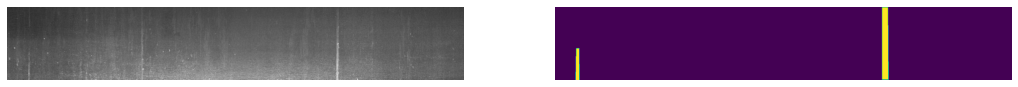

In [ ]:
show_images(t, figsize=(18,5))

### Custom Transform

Without the labels, we need a `Transform` to convert the RLEs into a mask. 

The `source` where we start from is `train_pivot` but can be also `train` (with the `ColReader` transform).

In [ ]:
train_pivot.head(2)

ClassId,0,1,2,3,4,n
ImageId,,,,,,
0002cc93b.jpg,NaN,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...,NaN,NaN,NaN,1
00031f466.jpg,-1,NaN,NaN,NaN,NaN,1


In [ ]:
train_pivot.reset_index().query("n > 1").head(2)

ClassId,ImageId,0,1,2,3,4,n
11,0025bde0c.jpg,NaN,NaN,NaN,8458 14 8707 35 8963 48 9219 71 9475 88 9731 88 9987 89 10243 89 10499 90 10755 90 11011 91 11267 91 11523 92 11779 92 12035 93 12291 93 12547 94 12803 94 13060 94 13316 94 13572 95 13828 95 14084 96 14340 96 14596 96 14852 96 15108 96 15364 96 15620 96 15876 96 16132 97 16388 97 16644 97 16900 97 17156 97 17412 97 17668 97 17925 96 18181 96 18437 96 18693 96 18949 96 19205 96 19462 95 19718 95 19974 95 20230 96 20486 96 20742 96 20999 95 21255 95 21511 95 21767 95 22023 95 22279 95 22536 94 22792 94 23048 94 23304 94 23560 94 23816 95 24073 94 24329 94 24585 94 24841 94 25097 94 25353 94 ...,315139 8 315395 15 315651 16 315906 17 316162 18 316418 19 316674 19 316930 20 317186 20 317441 22 317697 23 317953 23 318209 24 318465 25 318721 25 318977 26 319233 27 319489 27 319745 28 320001 28 320257 29 320513 30 320769 30 321025 31 321281 32 321537 32 321793 33 322049 34 322305 34 322561 35 322817 35 323073 36 323329 37 323585 37 323841 38 324097 38 324353 38 324609 38 324865 37 325121 37 325377 37 325633 37 325889 37 326145 37 326401 36 326657 36 326913 36 327169 36 327425 36 327681 36 327937 36 328193 35 328449 35 328705 35 328961 35 329217 35 329473 35 329729 34 329985 34 330241 ...,2
14,002fc4e19.jpg,NaN,146021 3 146275 10 146529 40 146783 46 147038 52 147292 59 147546 65 147800 70 148055 71 148311 72 148566 73 148822 74 149077 75 149333 76 149588 77 149844 78 150100 78 150357 75 150614 72 150870 70 151127 67 151384 64 151641 59 151897 53 152154 46 152411 22,145658 7 145901 20 146144 33 146386 47 146629 60 146872 73 147115 86 147364 93 147620 93 147876 93 148132 93 148388 93 148644 93 148900 93 149156 93 149412 93 149668 46,NaN,NaN,2


In [ ]:
train.head(2)

,ImageId,ClassId,EncodedPixels,ImageId_ClassId
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...,0002cc93b.jpg_1
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 296709 251 296965 251 297221 251 297477 251 297733 251 297989 251 298245 251 298564 188 298945 63,0007a71bf.jpg_3


A single item from `source` is the following `pd.Series`. First we use a item from `train_pivot` and then from `item_train`.

In [ ]:
item = train_pivot.iloc[6]
item_imgid = item.name
item_imgid

'000f6bf48.jpg'

In [ ]:
item_train = train.iloc[0]
item_train_imgid = item_train.iloc[0]
item_train_imgid

'0002cc93b.jpg'

In [ ]:
# export
class ReadImagePathFromIndex(Transform):
    """Read RLEs from `train_pivot`"""
    def __init__(self, suff='', pref=train_path, label_delim=None):
        store_attr()
        self.pref = str(pref) + os.path.sep if isinstance(pref, Path) else pref

    def encodes(self, row:pd.Series, **kwargs):
        o = row.name # ImageId
        if len(self.pref)==0 and len(self.suff)==0 and self.label_delim is None: return o
        if self.label_delim is None: return f'{self.pref}{o}{self.suff}'
        else: return o.split(self.label_delim) if len(o)>0 else []

With the `ReadImagePathFromIndex` transform we can get the image path from `train_pivot`.

In [ ]:
get_x = ReadImagePathFromIndex()
path = get_x(item)
test_eq(path, "../data/train_images/"+item_imgid)

In [ ]:
get_train_x = ColReader(0, pref=train_path)
path_train = get_train_x(item_train)
test_eq(path_train, "../data/train_images/"+item_train_imgid)

In [ ]:
#export
class ReadRLEs(Transform):
    """Read RLEs from `train_pivot`"""
    h, w = (256, 1600)
    
    def __init__(self, cols=2):
        self.cols = L(cols)
        self.c = len(self.cols)
        
    def encodes(self, row:pd.Series, **kwargs):
        if self.c == 1:
            rles = [''] * 4 # 4:class 1～4 (ch:0～3)
            rles[row["ClassId"]-1] = row["EncodedPixels"]
            return rles
        
        return [row[i] if not row[i] is np.nan else ''
                for i in self.cols]

The `ReadRLEs` transform need a setup with the RLEs columns. It takes a dataframe and returns a list of RLEs, one for each ClassIds.

In [ ]:
get_rles = ReadRLEs(cols=[1,2,3,4])
rles = get_rles(item)
test_eq(len(rles), 4)

In [ ]:
get_rles_train = ReadRLEs()
rles_train = get_rles_train(item_train)
test_eq(len(rles_train), 4)

In [ ]:
#export
class MakeMask(Transform):
    """Read RLEs list and return a np.array"""
    h, w = (256, 1600)
    
    def __init__(self, flatten=True):
        self.flatten = flatten
        
    def encodes(self, o:list, **kwargs):
        mask = np.zeros((self.h, self.w, 4), dtype=np.float32) # 4:class 1～4 (ch:0～3)
        
        for i in range(4):
            rle = o[i]
            if not rle is '':
                mask[:, :, i] = rle2mask(rle=rle, value=1, shape=(self.h,self.w))

        if self.flatten:
            classes = np.array(range(1,5))
            return (mask * classes).sum(-1)

        return mask

    def decodes(self, mask, **kwargs):
        mask = (mask * np.array(range(1,5))).sum(-1) if len(mask.shape) == 3 else mask
        return [mask2rle(np.where(mask==c, mask, 0)) for c in range(1,5)]

The `MakeMask` transform needs a list of RLEs and returns a mask with `(256, 1600)` shape if `flatten` is `True` (default). If `flatten` is `False`  returns a `(256, 1600, 4)` array.

In [ ]:
get_mask = MakeMask(flatten=False)
mask = get_mask(rles)
test_eq(mask.shape, (256,1600,4))

In [ ]:
get_mask = MakeMask()
mask = get_mask(rles)
test_eq(mask.shape, (256,1600))

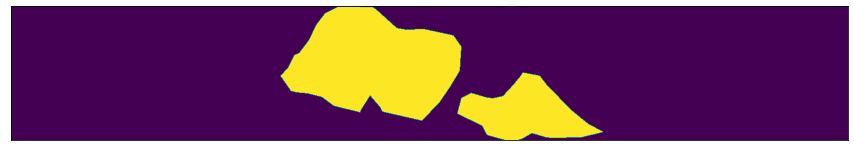

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks([])
plt.yticks([])
plt.imshow(mask);

In [ ]:
rle = get_mask.decode(mask)
test_eq(rle, rles)

In [ ]:
x_tfms = Pipeline([ReadImagePathFromIndex, PILImage.create])
y_tfms = Pipeline([ReadRLEs(cols=[1,2,3,4]), MakeMask(), PILMask.create])
dsets = Datasets(train_pivot, [x_tfms, y_tfms])

In [ ]:
t = dsets.train[6]
type(t), t[0], t[1]

(tuple, PILImage mode=RGB size=1600x256, PILMask mode=F size=1600x256)

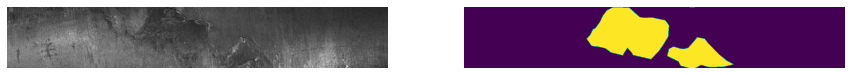

In [ ]:
show_images(t, figsize=(15,5))

In [ ]:
def image2tensor(img):
    "Transform image to byte tensor in `c*h*w` dim order."
    res = tensor(img)
    if res.dim()==2: res = res.unsqueeze(-1)
    return res.permute(2,0,1)

class ToTensor(Transform):
    "Convert item to appropriate tensor class"
    order = 5
    
    def encodes(self, o:PILBase): return o._tensor_cls(image2tensor(o))    
    def encodes(self, o:PILImage): return o._tensor_cls(image2tensor(o))    
    def encodes(self, o:PILMask): return o._tensor_cls(image2tensor(o)[0])

In [ ]:
dsets.dataloaders(bs=4, after_item=[AddMaskCodes, ToTensor], after_batch=IntToFloatTensor, verbose=True)

Setting up after_item: Pipeline: AddMaskCodes -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}


In [ ]:
dls = TfmdDL(dsets, bs=4, after_item=[AddMaskCodes, ToTensor], after_batch=IntToFloatTensor)

In [ ]:
x, targ = dls.one_batch()
x.shape, targ.shape

(torch.Size([4, 3, 256, 1600]), torch.Size([4, 256, 1600]))

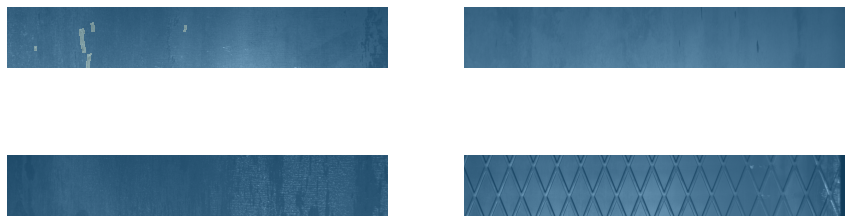

In [ ]:
dls.show_batch(figsize=(15,5))

In [ ]:
#export
class ChannelMask(Transform):
    """Prepare Mask to 4-channel models"""
    def encodes(self, o:TensorMask):
        new_masks = []
        for mask in o:
            new_mask = torch.zeros(4, mask.shape[0], mask.shape[1])
            for i in range(4):
                new_mask[i] = torch.where(mask==(i+1), 1, 0)
            new_masks.append(new_mask)
        
        return torch.stack(new_masks, axis=0)
    
    def decodes(self, o:TensorMask):
        classes = torch.tensor(range(1,5)).unsqueeze(-1).unsqueeze(-1)
        new_masks = []
        for mask in o:
            new_masks.append((mask * classes).sum(0))
        return torch.stack(new_masks, axis=0)

In [ ]:
tfm = ChannelMask()
ch_mask = tfm(targ)
ch_mask.shape

torch.Size([4, 4, 256, 1600])

In [ ]:
decoded_mask = tfm.decodes(ch_mask)
decoded_mask.shape

torch.Size([4, 256, 1600])

In [ ]:
test_close(decoded_mask, targ)

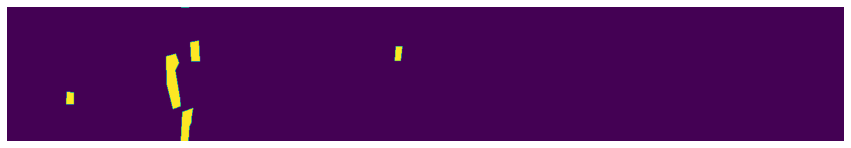

In [ ]:
show_image(decoded_mask[0], figsize=(15,5));

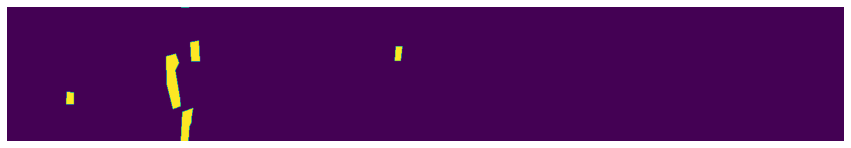

In [ ]:
show_image(targ[0], figsize=(15,5));

## Pure Pytorch

The fast.ai Datablock API is very useful, we can load the images and apply transforms very quickly.
On the other side it can be a limit when experimenting with other models or with custom transformations and requires a deeper knoledge of the high-level API. 

Here some functions and classes from [this kernel](https://www.kaggle.com/rishabhiitbhu/unet-starter-kernel-pytorch-lb-0-88) for pure Pytorch `Dataset` and `DataLoader`.

In [ ]:
# export
def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5),  # only horizontal flip for now
            ]
        )
    list_transforms.extend(
        [
            alb.Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [ ]:
#missing
get_tsfms = get_transforms('train', *imagenet_stats)
get_tsfms

Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  Normalize(always_apply=False, p=1, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [ ]:
# export
class SteelDataset(Dataset):

    def __init__(self, df, mean, std, phase):
        self.df = df
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, df=self.df)
        image_path = train_path / image_id
        img = cv2.imread(str(image_path))
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']         # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1)  # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)

In [ ]:
steel_ds = SteelDataset(train_pivot, *imagenet_stats, 'train')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.8953) tensor(2.6400) torch.Size([4, 256, 1600])


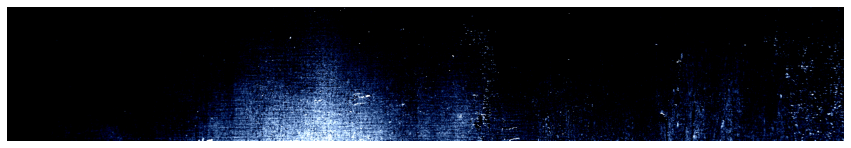

In [ ]:
# missing
x,y = steel_ds[0]

print(x.min(), x.max(), y.shape)
show_image(x, figsize=(15,5));

In [ ]:
get_tsfms.transforms

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_metadata.ipynb.
Converted 02_masks.ipynb.
Converted 03_datasets.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_metrics.ipynb.
Converted 06_loss.ipynb.
Converted 07_trainer.ipynb.
Converted 08_predict.ipynb.
Converted 09_visualize.ipynb.
Converted 10_fastai.classifier.ipynb.
Converted 11_fastai.seg_unet_resnet34.ipynb.
Converted 12_fastai.seg_unet_xresnext34.ipynb.
Converted 13_torch.seg_fpn_resnet34.ipynb.
Converted 14_torch.seg_unet_resnet34.ipynb.
Converted 15_torch.seg_unet_resnet18.ipynb.
Converted 21_ensemble_unet_fpn_resnet34.ipynb.
Converted index.ipynb.
